In [398]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as pl
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima_model import ARIMA

In [197]:
df = pd.read_csv('../data/avocado_modeling_file.csv')

### Linear Regression for a baseline

In [279]:


df_lr = df.drop('Date', axis = 1).select_dtypes('number')
target = 'AveragePrice'
X = df_lr.drop(target, inplace = False, axis = 1)
y = df_lr[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state = 12)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
preds = regressor.predict(X_train)
resid = (preds-y_train).values

In [280]:
y = np.zeros(len(x))

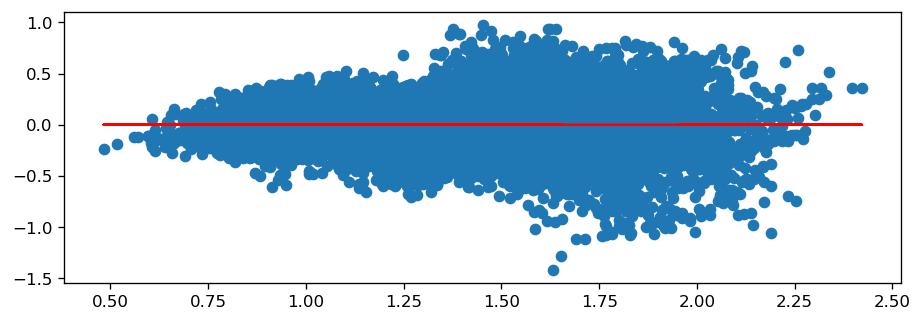

In [281]:
plt.scatter(preds, resid)
plt.plot(x, y, color = 'red')

In [203]:
r2_score(y_train, preds)

0.635612395816022

In [204]:
mean_squared_error(y_train, preds)

0.058919556530191784

### ARIMA forecast for Total Volume

In [205]:

df['Date'] = pd.to_datetime(df['Date'])
df_arima = df.set_index('Date')
pd.DatetimeIndex(df_arima.index).to_period('W')
df_arima = df_arima.select_dtypes(['number', 'datetime'])

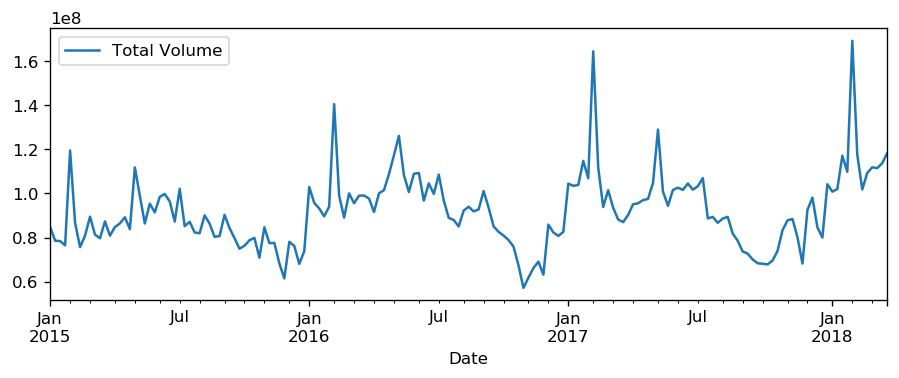

In [261]:
#Volume seems seasonal -- can we use an ARIMA model for this or should we go SARIMA?

test_gb = df.groupby('Date', as_index = False).agg({'Total Volume':'sum'})
test_gb.plot('Date', 'Total Volume')

In [253]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(test_gb['Total Volume'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.932609
p-value: 0.041685


In [254]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

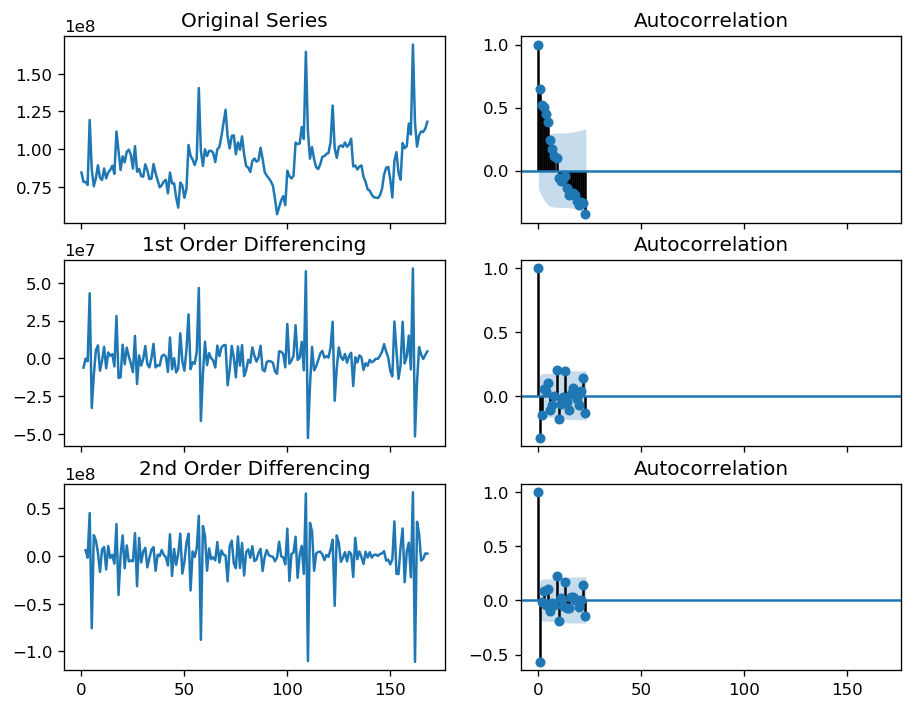

In [255]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(test_gb['Total Volume']); axes[0, 0].set_title('Original Series')
plot_acf(test_gb['Total Volume'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(test_gb['Total Volume'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(test_gb['Total Volume'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(test_gb['Total Volume'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(test_gb['Total Volume'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [256]:
from pmdarima.arima.utils import ndiffs

print('adf test: ' + str(ndiffs(test_gb['Total Volume'], test='adf')))
print('kpss test: ' + str(ndiffs(test_gb['Total Volume'], test='kpss')))
print('pp test: ' + str(ndiffs(test_gb['Total Volume'], test='pp')))

adf test: 1
kpss test: 0
pp test: 0


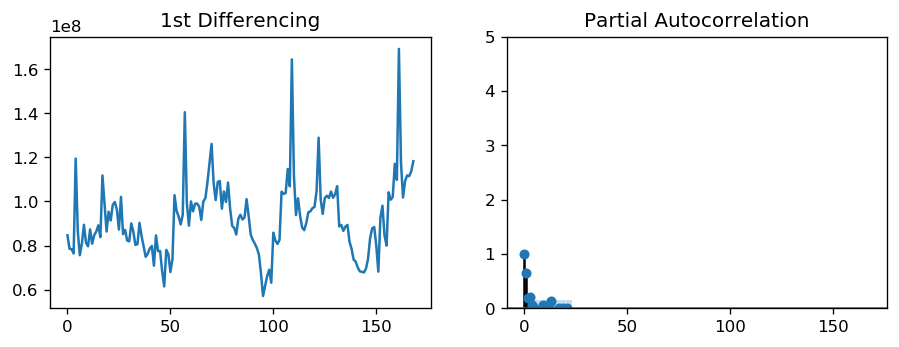

In [257]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(test_gb['Total Volume']); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(test_gb['Total Volume'], ax=axes[1])

plt.show()

In [356]:
model_df = test_gb.set_index('Date')
model = ARIMA(model_df['Total Volume'], order=(1,1,1), freq = 'W')
model_fit = model.fit(disp=0)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Total Volume   No. Observations:                  168
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2981.953
Method:                       css-mle   S.D. of innovations       12358564.301
Date:                Tue, 07 Apr 2020   AIC                           5971.907
Time:                        16:22:21   BIC                           5984.402
Sample:                    01-11-2015   HQIC                          5976.978
                         - 03-25-2018                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                     2e+05   4.36e+05      0.458      0.647   -6.55e+05    1.06e+06
ar.L1.D.Total Volume     0.1266      0.143      0.884      0.377      -0.154       0.407
ma.L1.D.Total Volume    -0.6037      0.114     -5.297      0.000      -0.827      -0.380
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            7.8967           +0.0000j            7.8967            0.0000
MA.1            1.6565           +0.0000j            1.6565            0.0000
-----------------------------------------------------------------------------
"""

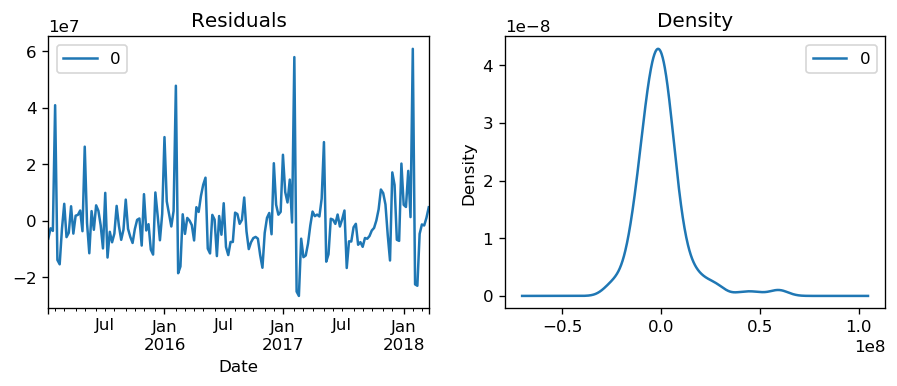

In [357]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

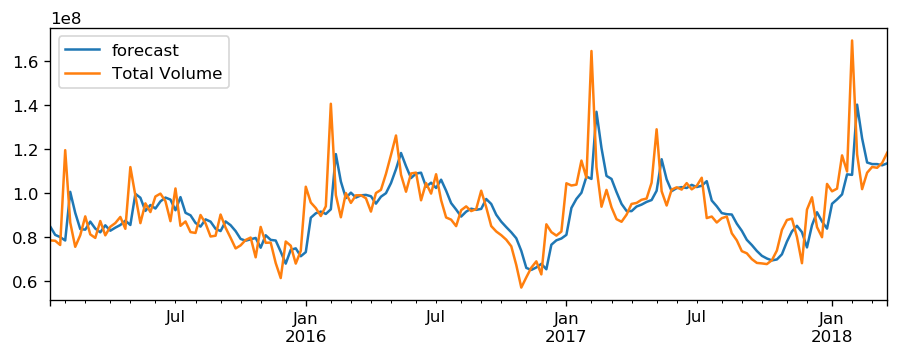

In [358]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [359]:
train = model_df.sort_index()[:150]
test = model_df.sort_index()[150:]

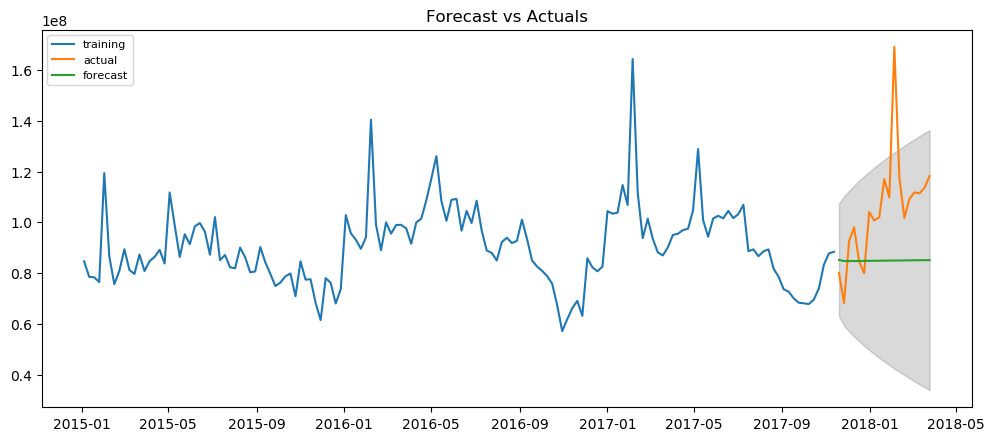

In [360]:
model = ARIMA(train, order=(1, 1, 1), freq = 'W')  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(19, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [361]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

In [362]:
forecast_accuracy(fc, test.values.flatten())

{'mape': 0.19838147207408932,
 'me': -19803715.742667355,
 'mae': 22615122.512883462,
 'mpe': -0.15949307372598964,
 'rmse': 28538874.281760793,
 'corr': 0.34633851423199263,
 'minmax': 0.19549960481943662}

In [393]:
import pmdarima as pm

model = pm.auto_arima(model_df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=12,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=5629.237, BIC=5644.518, Time=0.180 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=True); AIC=5774.920, BIC=5781.032, Time=0.011 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 12) (constant=True); AIC=5661.125, BIC=5673.350, Time=0.109 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 12) (constant=True); AIC=5709.102, BIC=5721.327, Time=0.137 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 12) (constant=False); AIC=5774.918, BIC=5777.975, Time=0.009 seconds
Fit ARIMA: (1, 0, 1)x(0, 1, 0, 12) (constant=True); AIC=5685.037, BIC=5697.262, Time=0.063 seconds
Fit ARIMA: (1, 0, 1)x(1, 1, 1, 12) (constant=True); AIC=5631.228, BIC=5649.566, Time=0.168 seconds
Fit ARIMA: (1, 0, 1)x(0, 1, 2, 12) (constant=True); AIC=5631.165, BIC=5649.503, Time=0.475 seconds
Fit ARIMA: (1, 0, 1)x(1, 1, 0, 12) (constant=True); AIC=5654.413, BIC=5669.694, Time=0.159 seconds
Fit ARIMA: (1, 0, 1)x(1, 1, 2, 12) (constant=True); AIC=5632.797,

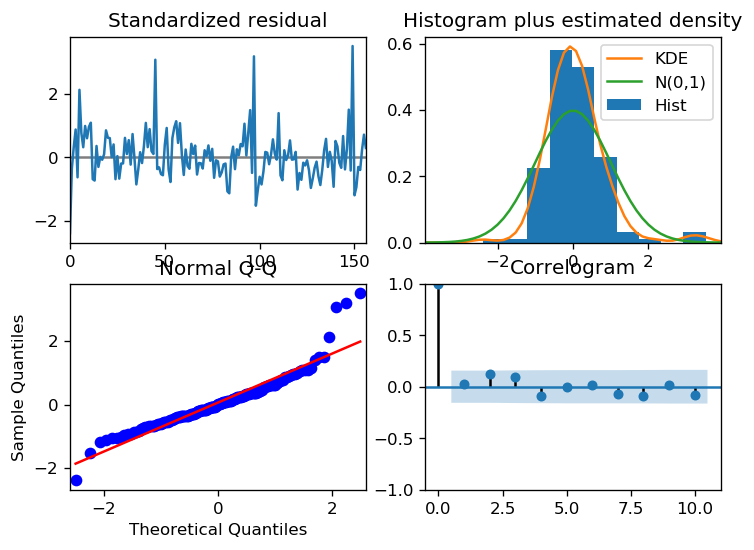

In [395]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

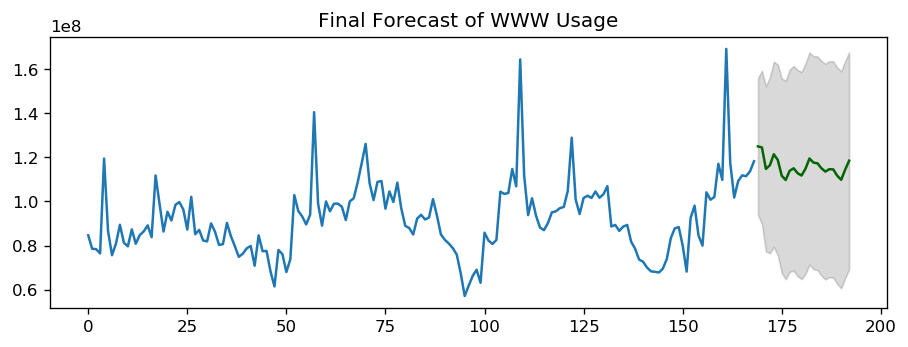

In [396]:
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(test_gb), len(test_gb)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(test_gb['Total Volume'])
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()

### Meh, I'm not impressed by either the ARIMA or SARIMAX models

In [399]:
rf_tv_model = RandomForestRegressor(random_state=4)

In [400]:
df.columns

Index(['Date', 'AveragePrice', 'Total Volume', '4046', '4225', '4770',
       'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags',
       ...
       'region_tmp_South Carolina', 'region_tmp_South Central',
       'region_tmp_Southeast', 'region_tmp_Spokane', 'region_tmp_St Louis',
       'region_tmp_Syracuse', 'region_tmp_Tampa', 'region_tmp_Total US',
       'region_tmp_West', 'region_tmp_West Tex New Mexico'],
      dtype='object', length=188)

In [ ]:
X_tv = df[[x for x in df.colums if ]]